In [737]:
%matplotlib inline
from __future__ import division
import peakutils as pk
import matplotlib.pyplot as plt
import numpy as np
import os
import os.path
import scipy.stats as stats
from scipy.optimize import curve_fit
import matplotlib.patches as patches

# Utilities

In [738]:
wd = os.getcwd()
rootdatadir = os.path.join(wd, "data/")

In [739]:
def spelength(filename, filedir):
    with open(os.path.join(filedir, filename)) as f:
        data = f.read()
    data = data.split("\n")
    datalen = data[11].split()
    datalen = int(datalen[1])
    return datalen

In [740]:
def spedata(filename, filedir):
    firstdataline = 13
    with open(os.path.join(filedir, filename)) as f:
        data = f.read()
    data = data.split("\n")
    data = data[firstdataline:firstdataline + spelength(filename, filedir)]
    data = np.array([int(i) for i in data])
    return data

In [741]:
def spetime(filename, filedir):
    with open(os.path.join(filedir, filename)) as f:
        data = f.read()
    data = data.split("\n")
    time = data[9].split(" ")[0]
    return int(time)

In [742]:
def sigma2fwhm(sigma):
    return 2 * np.sqrt(2 * np.log(2)) * np.abs(sigma)

def sigma2res(sigma, e):
    return e / sigma2fwhm(sigma)

# Data analysis

## MCA Linearity

In [743]:
datadir = os.path.join(rootdatadir, "maestro/Spectra/")

In [744]:
filename = "thulab8mcalinear.Spe"

In [745]:
d = spedata(filename, datadir)

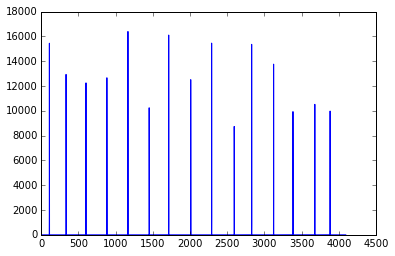

In [746]:
plt.plot(d)
plt.show()

In [747]:
volts = np.array([0.28,0.84,1.50,2.20,2.92,3.64,4.32,5.04,5.76,6.56,7.12,7.84,8.60,9.20,9.80])
channels = pk.indexes(d)

In [748]:
func = stats.linregress(volts, channels)
print(func.slope)
print(func.intercept)
print(func.rvalue ** 2)

396.398660247
5.15555414295
0.999902663718


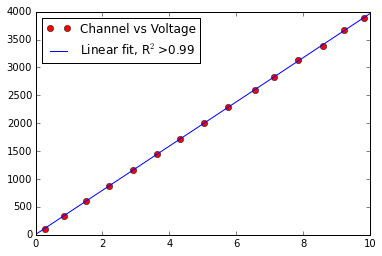

In [749]:
f = plt.figure()
ax1 = f.add_subplot(111)
ax1.plot(volts, channels, 'ro', label='Channel vs Voltage')
ax1.plot(
    np.linspace(0,10,100), 
    [func.slope * x + func.intercept for x in np.linspace(0,10,100)],
    label=r'Linear fit, R$^2$>0.99'
)
ax1.legend(loc='upper left')
plt.show()

# Spectroscopy with HPGE detector

In [750]:
datadir = os.path.join(rootdatadir, "maestro/Spectra/efrancis/")

In [751]:
peak_energies = []
peak_channels = []

In [752]:
def gauss(x, mu, sigma, a):
    fp = a / np.sqrt(2 * np.pi * sigma ** 2)
    exppart = - (x - mu) ** 2 / (2 * sigma) ** 2
    
    return fp * np.exp(exppart)

## Determine energy to channel relationship

### Background

In [753]:
bkg = spedata("bkg.Spe", datadir) / spetime("bkg.Spe", datadir)

In [754]:
print(bkg)

[ 0.  0.  0. ...,  0.  0.  0.]


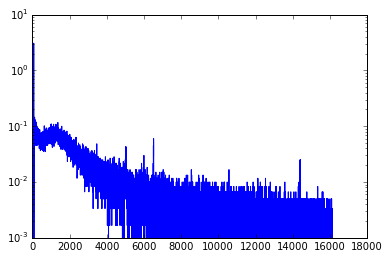

In [755]:
plt.plot(bkg)
plt.yscale('log')
plt.show()

### Na-22

In [756]:
na22 = spedata("Na22.Spe", datadir) / spetime("Na22.Spe", datadir) - bkg

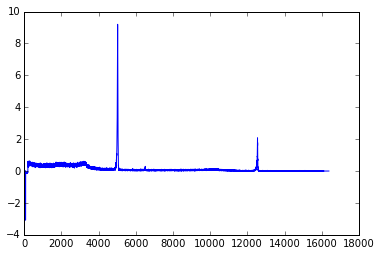

In [757]:
plt.plot(na22)
plt.show()

In [758]:
pk.indexes(na22, thres=0.4, min_dist=300)

array([ 5024, 12544])

In [759]:
map(peak_energies.append, [511, 1274])
map(peak_channels.append, pk.indexes(na22, thres=0.4, min_dist=300))

[None, None]

### Mn-54

In [760]:
mn54 = spedata("Mn54.Spe", datadir) / spetime("Mn54.Spe", datadir) - bkg

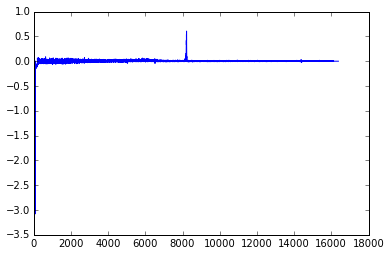

In [761]:
plt.plot(mn54)
plt.show()

In [762]:
pk.indexes(mn54, thres=0.9, min_dist=300)

array([8217])

In [763]:
map(peak_energies.append, [835])
map(peak_channels.append, pk.indexes(mn54, thres=0.9, min_dist=300))

[None]

## Co-57

In [764]:
co57 = spedata("Co57.Spe", datadir) / spetime("Co57.Spe", datadir) - bkg

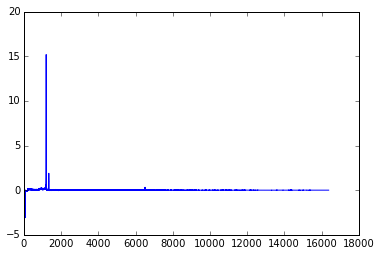

In [765]:
plt.plot(co57)
plt.show()

In [766]:
pk.indexes(co57, thres=0.24, min_dist=20)

array([1194, 1336])

In [767]:
map(peak_energies.append, [122, 136])
map(peak_channels.append, pk.indexes(co57, thres=0.24, min_dist=20))

[None, None]

## Co-60

In [768]:
co60 = spedata("Co60.Spe", datadir) / spetime("Co60.Spe", datadir) - bkg

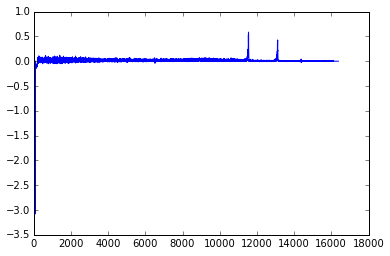

In [769]:
plt.plot(co60)
plt.show()

In [770]:
pk.indexes(co60, thres=0.9, min_dist=50)

array([11547, 13116])

In [771]:
map(peak_energies.append, [1173, 1332])
map(peak_channels.append, pk.indexes(co60, thres=0.9, min_dist=50))

[None, None]

## Cd-109

In [772]:
cd109 = spedata("Cd109.Spe", datadir) / spetime("Cd109.Spe", datadir) - bkg

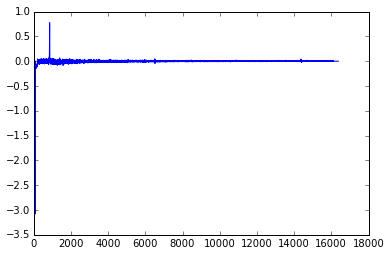

In [773]:
plt.plot(cd109)
plt.show()

In [774]:
pk.indexes(cd109, thres=0.9, min_dist=50)

array([858])

In [775]:
map(peak_energies.append, [88.04])
map(peak_channels.append, pk.indexes(cd109, thres=0.9, min_dist=50))

[None]

## Ba-133

In [776]:
ba133 = spedata("Ba133.Spe", datadir) / spetime("Ba133.Spe", datadir) - bkg

[ 782 2715 2974 3499 3773]
[  782.46998713  2714.3001057   2974.75706087  3498.12342877  3772.44441529]


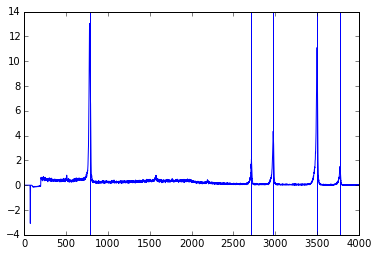

In [777]:
ba133ind = pk.indexes(ba133[500:4000], thres=0.1, min_dist=90) + 500
print(ba133ind)
ba133peak = pk.interpolate(np.array([i for i in range(len(ba133))]), ba133, ind=ba133ind)
print(ba133peak)

plt.plot(ba133)
plt.xlim(0,4000)
for x in ba133peak:
    plt.axvline(x=x)
plt.show()

In [778]:
map(peak_energies.append, [80.9971, 276.398, 302.853, 356.017, 383.851])
map(peak_channels.append, ba133peak)

[None, None, None, None, None]

## Cs-137

In [779]:
cs137 = spedata("Cs137.Spe", datadir) / spetime("Cs137.Spe", datadir) - bkg

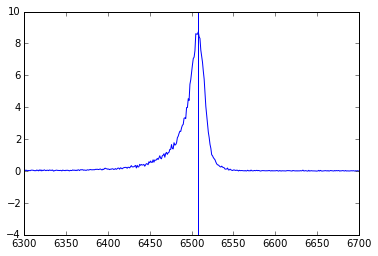

In [780]:
plt.plot(cs137)
plt.xlim(6300,6700)
plt.axvline(x=6508)
plt.show()

In [781]:
cs137ind = pk.indexes(cs137[6300:6700], thres=0.1, min_dist=90) + 6300
print(cs137ind)

[6508]


In [782]:
cs137peak = pk.interpolate(np.array([i for i in range(len(ba133))]), ba133, ind=cs137ind)
print(cs137peak)

[ 6501.21402874]


In [783]:
map(peak_energies.append, [661.7])
map(peak_channels.append, cs137ind)

[None]

## Energy to channel

In [784]:
print(peak_energies)
print(peak_channels)

[511, 1274, 835, 122, 136, 1173, 1332, 88.04, 80.9971, 276.398, 302.853, 356.017, 383.851, 661.7]
[5024, 12544, 8217, 1194, 1336, 11547, 13116, 858, 782.46998712801496, 2714.3001056999442, 2974.7570608744745, 3498.123428773114, 3772.4444152948104, 6508]


In [785]:
np.polyfit(y=peak_energies, x=peak_channels, deg=1, full=True)

(array([ 0.10149066,  0.986372  ]),
 array([ 0.8264144]),
 2,
 array([ 1.33401429,  0.46947404]),
 3.1086244689504383e-15)

In [786]:
def channel2energy(ch):
    fit = stats.linregress(peak_channels, peak_energies)
    a = fit.slope
    b = fit.intercept
    return a * ch + b

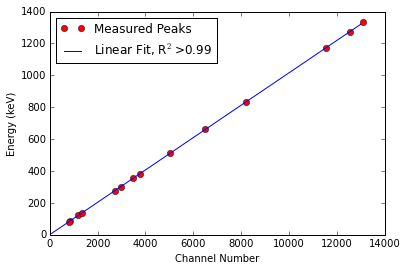

In [787]:
plt.plot(peak_channels, peak_energies, 'ro', label="Measured Peaks")
x = np.linspace(0, 13000, 13000)
plt.plot(x, channel2energy(x), label=r'Linear Fit, R$^2$>0.99')
plt.ylabel("Energy (keV)")
plt.xlabel("Channel Number")
# plt.title("Decay Energy vs. Peak Channel")
plt.legend(loc="upper left")
plt.show()

In [788]:
fit = stats.linregress(peak_channels, peak_energies)
fit.rvalue ** 2

0.99999968290223662

In [789]:
energies = channel2energy(np.arange(0, len(bkg), 1))

In [790]:
print(energies)

[  9.86371996e-01   1.08786266e+00   1.18935332e+00 ...,   1.66340343e+03
   1.66350492e+03   1.66360641e+03]


In [791]:
len(energies)

16383

# Here we go again!

## Background

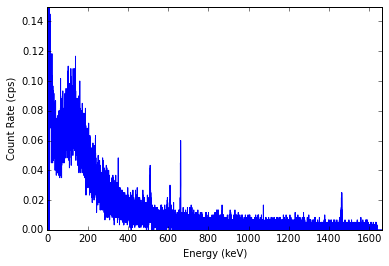

In [792]:
plt.plot(energies, bkg, '-')
plt.ylim(0,0.15)
plt.xlim(0,max(energies))
plt.ylabel("Count Rate (cps)")
plt.xlabel("Energy (keV)")
plt.show()

## Na-22

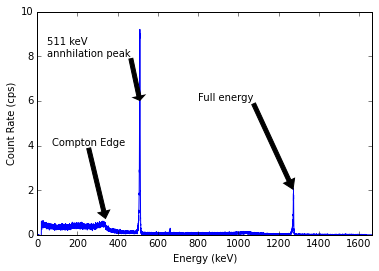

In [793]:
plt.plot(energies, na22, label="Background Corrected")
plt.ylim(0,10)
plt.xlim(0,max(energies))
plt.ylabel("Count Rate (cps)")
plt.xlabel("Energy (keV)")
# plt.title("Na-22 Spectrum with HPGE Detector")

plt.annotate('511 keV\nannhilation peak', xy=(511,6), 
             xytext=(50,8), arrowprops=dict(facecolor="black", shrink=0.01))
plt.annotate('Full energy', xy=(1274,2), 
             xytext=(800,6), arrowprops=dict(facecolor="black", shrink=0.01))
plt.annotate('Compton Edge', xy=(0.667*511,0.7), 
             xytext=(75,4), arrowprops=dict(facecolor="black", shrink=0.01))
plt.show()

### 511 keV peak

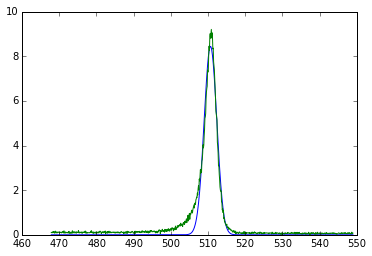

In [794]:
popt, pcov = curve_fit(gauss, energies[4600:5400], na22[4600:5400], p0=[100, 511, 0.8])
plt.plot(energies[4600:5400], gauss(energies[4600:5400], *popt))
plt.plot(energies[4600:5400], na22[4600:5400])
plt.show()

In [795]:
popt

array([ 510.64691963,    1.20299897,   25.45255754])

In [796]:
print("Area under the curve: {}".format(sum([na22[i] for i in range(len(na22)) if na22[i] > 0 ])))
print("Photopeak efficiency: {}".format(popt[2] / sum([na22[i] for i in range(len(na22)) if na22[i] > 0 ])))

Area under the curve: 2338.53666667
Photopeak efficiency: 0.0108839676998


In [797]:
print(popt[1])
print("FWHM: {}".format(sigma2fwhm(popt[1])))
print("Resolution: {}".format(sigma2res(popt[1], popt[0])))

1.20299896885
FWHM: 2.83284608599
Resolution: 180.259323708


### 1274 keV peak

[  1.27372279e+03  -1.16745656e+00   4.47797941e+00]


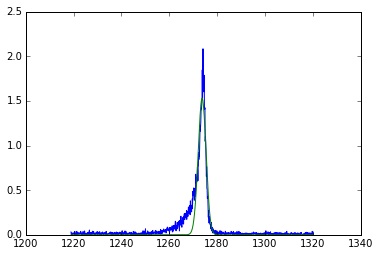

In [798]:
popt, pcov = curve_fit(gauss, energies[12000:13000], na22[12000:13000], p0=[100, 1274, 0.8])
print(popt)
plt.plot(energies[12000:13000], na22[12000:13000])
plt.plot(energies[12000:13000], gauss(energies[12000:13000], *popt))
plt.ylim(0,2.5)
plt.show()

In [799]:
print("Area under the curve: {}".format(sum([na22[i] for i in range(len(na22)) if na22[i] > 0 ])))
print("Photopeak efficiency: {}".format(popt[2] / sum([na22[i] for i in range(len(na22)) if na22[i] > 0 ])))

Area under the curve: 2338.53666667
Photopeak efficiency: 0.00191486388842


In [800]:
print(popt[1])
print("FWHM: {}".format(sigma2fwhm(popt[1])))
print("Resolution: {}".format(sigma2res(popt[1], popt[0])))

-1.16745655746
FWHM: 2.74915010321
Resolution: 463.315113777


# Mn-54

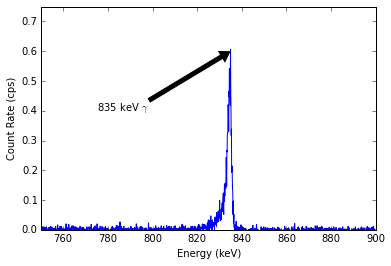

In [801]:
plt.plot(energies, mn54)
plt.ylim(0,0.75)
plt.xlim(0,max(energies))
plt.xlim(750,900)
plt.ylabel("Count Rate (cps)")
plt.xlabel("Energy (keV)")
# plt.title("Mn-54 Spectrum with HPGE Detector")
plt.annotate(r'835 keV $\gamma$', xy=(835,0.6), 
             xytext=(775,0.4), arrowprops=dict(facecolor="black", shrink=0.01))
plt.show()

### 835 keV peak

[  8.34373165e+02  -7.34266952e-01   8.61075322e-01]


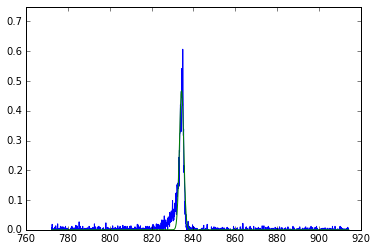

In [802]:
popt, pcov = curve_fit(gauss, energies[7600:9000], mn54[7600:9000], p0=[1, 835, 0.8])
print(popt)
plt.plot(energies[7600:9000], mn54[7600:9000])
plt.plot(energies[7600:9000], gauss(energies[7600:9000], *popt))
plt.ylim(0,0.75)
plt.show()

In [803]:
print("Area under the curve: {}".format(sum([mn54[i] for i in range(len(mn54)) if mn54[i] > 0 ])))
print("Photopeak efficiency: {}".format(popt[2] / sum([mn54[i] for i in range(len(mn54)) if mn54[i] > 0 ])))

Area under the curve: 82.5433333333
Photopeak efficiency: 0.0104317973049


In [804]:
print(popt[1])
print("FWHM: {}".format(sigma2fwhm(popt[1])))
print("Resolution: {}".format(sigma2res(popt[1], popt[0])))

-0.734266951768
FWHM: 1.72906653643
Resolution: 482.557002528


## Co-57

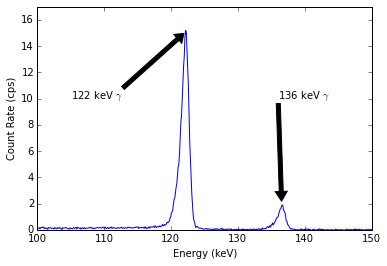

In [805]:
plt.plot(energies, co57)
plt.ylim(0,17)
plt.xlim(100,150)
plt.ylabel("Count Rate (cps)")
plt.xlabel("Energy (keV)")
# plt.title("Co-57 Spectrum with HPGE Detector")
plt.annotate(r'122 keV $\gamma$', xy=(122,15), 
             xytext=(105,10), arrowprops=dict(facecolor="black", shrink=0.01))
plt.annotate(r'136 keV $\gamma$', xy=(136.5,2.1), 
             xytext=(136,10), arrowprops=dict(facecolor="black", shrink=0.01))
plt.show()

### 122 keV

[ 122.07018214   -0.44418378   15.69099311]


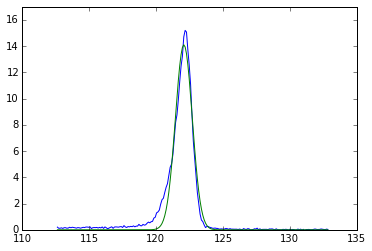

In [806]:
popt, pcov = curve_fit(gauss, energies[1100:1300], co57[1100:1300], p0=[1, 122, 0.8])
print(popt)
plt.plot(energies[1100:1300], co57[1100:1300])
plt.plot(energies[1100:1300], gauss(energies[1100:1300], *popt))
plt.ylim(0,17)
plt.show()

In [807]:
print("Area under the curve: {}".format(sum([co57[i] for i in range(len(co57)) if co57[i] > 0 ])))
print("Photopeak efficiency: {}".format(popt[2] / sum([co57[i] for i in range(len(co57)) if co57[i] > 0 ])))

Area under the curve: 413.2
Photopeak efficiency: 0.0379743298952


In [808]:
print(popt[1])
print("FWHM: {}".format(sigma2fwhm(popt[1])))
print("Resolution: {}".format(sigma2res(popt[1], popt[0])))

-0.444183781988
FWHM: 1.0459728735
Resolution: 116.704921549


### 136 keV

[ 136.46159336   -0.45145416    1.90485973]


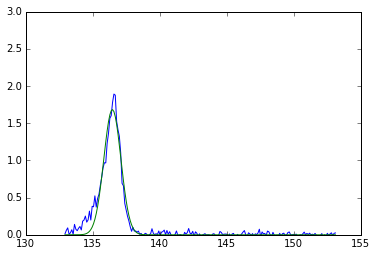

In [809]:
popt, pcov = curve_fit(gauss, energies[1300:1500], co57[1300:1500], p0=[1, 122, 0.8])
print(popt)
plt.plot(energies[1300:1500], co57[1300:1500])
plt.plot(energies[1300:1500], gauss(energies[1300:1500], *popt))
plt.ylim(0,3)
plt.show()

In [810]:
print("Area under the curve: {}".format(sum([co57[i] for i in range(len(co57)) if co57[i] > 0 ])))
print("Photopeak efficiency: {}".format(popt[2] / sum([co57[i] for i in range(len(co57)) if co57[i] > 0 ])))

Area under the curve: 413.2
Photopeak efficiency: 0.00461001871694


In [811]:
print(popt[1])
print("FWHM: {}".format(sigma2fwhm(popt[1])))
print("Resolution: {}".format(sigma2res(popt[1], popt[0])))

-0.451454159211
FWHM: 1.06309330352
Resolution: 128.362762622


## Co-60

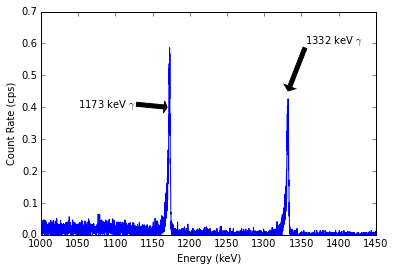

In [812]:
f = plt.figure()
ax1 = f.add_subplot(111)
ax1.plot(energies, co60)
ax1.set_ylim(0,0.7)
ax1.set_xlim(1000,1450)
ax1.set_ylabel("Count Rate (cps)")
ax1.set_xlabel("Energy (keV)")
# ax1.set_title("Co-60 Spectrum with HPGE Detector")
ax1.annotate(r'1173 keV $\gamma$', xy=(1170,0.4), 
             xytext=(1050,0.4), arrowprops=dict(facecolor="black", shrink=0.01))
ax1.annotate(r'1332 keV $\gamma$', xy=(1332,0.45), 
             xytext=(1355,0.6), arrowprops=dict(facecolor="black", shrink=0.01))
plt.show()

### 1173 keV peak

[  1.17247821e+03  -9.54514966e-01   1.06861437e+00]


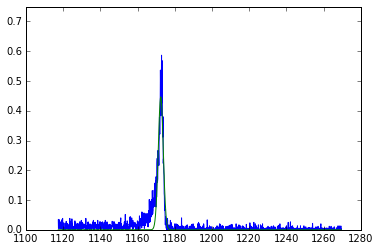

In [813]:
popt, pcov = curve_fit(gauss, energies[11000:12500], co60[11000:12500], p0=[1, 1173, 0.8])
print(popt)
plt.plot(energies[11000:12500], co60[11000:12500])
plt.plot(energies[11000:12500], gauss(energies[11000:12500], *popt))
plt.ylim(0,0.75)
plt.show()

In [814]:
print("Area under the curve: {}".format(sum([co60[i] for i in range(len(co60)) if co60[i] > 0 ])))
print("Photopeak efficiency: {}".format(popt[2] / sum([co60[i] for i in range(len(co60)) if co60[i] > 0 ])))

Area under the curve: 250.383333333
Photopeak efficiency: 0.00426791333286


In [815]:
print(popt[1])
print("FWHM: {}".format(sigma2fwhm(popt[1])))
print("Resolution: {}".format(sigma2res(popt[1], popt[0])))

-0.954514966065
FWHM: 2.24771097537
Resolution: 521.632105943


### 1332 keV

[  1.33156956e+03  -9.86336233e-01   8.93371639e-01]


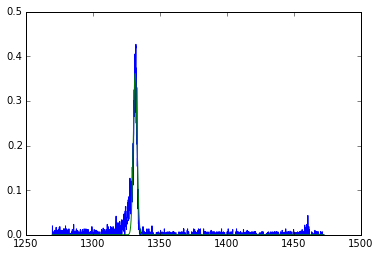

In [816]:
popt, pcov = curve_fit(gauss, energies[12500:14500], co60[12500:14500], p0=[1, 1332, 0.8])
print(popt)
plt.plot(energies[12500:14500], co60[12500:14500])
plt.plot(energies[12500:14500], gauss(energies[12500:14500], *popt))
plt.ylim(0,0.5)
plt.show()

In [817]:
print("Area under the curve: {}".format(sum([co60[i] for i in range(len(co60)) if co60[i] > 0 ])))
print("Photopeak efficiency: {}".format(popt[2] / sum([co60[i] for i in range(len(co60)) if co60[i] > 0 ])))

Area under the curve: 250.383333333
Photopeak efficiency: 0.00356801559955


In [818]:
print(popt[1])
print("FWHM: {}".format(sigma2fwhm(popt[1])))
print("Resolution: {}".format(sigma2res(popt[1], popt[0])))

-0.98633623328
FWHM: 2.32264433327
Resolution: 573.298951731


## Cd-109

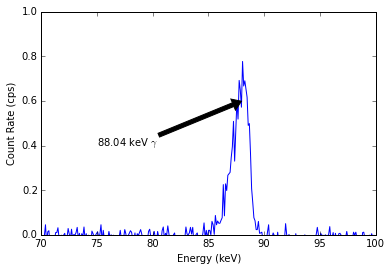

In [819]:
plt.plot(energies, cd109)
plt.ylim(0,1)
plt.xlim(70,100)
plt.ylabel("Count Rate (cps)")
plt.xlabel("Energy (keV)")
# plt.title("Cd-109 Spectrum with HPGE Detector")
plt.annotate(r'88.04 keV $\gamma$', xy=(88.04,0.6), 
             xytext=(75,0.4), arrowprops=dict(facecolor="black", 
                                                shrink=0.01))
plt.show()

### 88.04 keV peak

[ 87.91714735  -0.51800147   0.88231971]


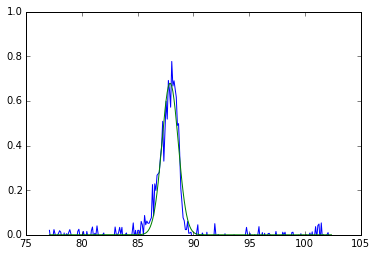

In [820]:
popt, pcov = curve_fit(gauss, energies[750:1000], cd109[750:1000], p0=[1, 88.04, 0.8])
print(popt)
plt.plot(energies[750:1000], cd109[750:1000])
plt.plot(energies[750:1000], gauss(energies[750:1000], *popt))
plt.ylim(0,1)
plt.show()

In [821]:
print("Area under the curve: {}".format(sum([cd109[i] for i in range(len(cd109)) if cd109[i] > 0 ])))
print("Photopeak efficiency: {}".format(popt[2] / sum([cd109[i] for i in range(len(cd109)) if cd109[i] > 0 ])))

Area under the curve: 42.65
Photopeak efficiency: 0.0206874491794


In [822]:
print(popt[1])
print("FWHM: {}".format(sigma2fwhm(popt[1])))
print("Resolution: {}".format(sigma2res(popt[1], popt[0])))

-0.518001468075
FWHM: 1.21980024038
Resolution: 72.075036908


## Ba-133

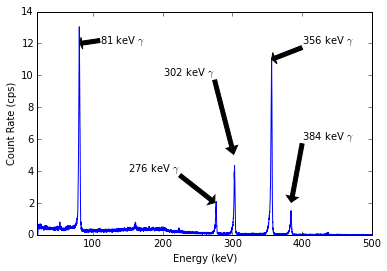

In [823]:
plt.plot(energies, ba133)
plt.ylim(0,14)
plt.xlim(20,500)
plt.ylabel("Count Rate (cps)")
plt.xlabel("Energy (keV)")
# plt.title("Ba-133 Spectrum with HPGE Detector")
plt.annotate(r'81 keV $\gamma$', xy=(81,12), 
             xytext=(110,12), arrowprops=dict(facecolor="black", shrink=0.01))
plt.annotate(r'276 keV $\gamma$', xy=(275,2), 
             xytext=(150,4), arrowprops=dict(facecolor="black", shrink=0.01))
plt.annotate(r'302 keV $\gamma$', xy=(302,5), 
             xytext=(200,10), arrowprops=dict(facecolor="black", shrink=0.01))
plt.annotate(r'356 keV $\gamma$', xy=(356,11), 
             xytext=(400,12), arrowprops=dict(facecolor="black", shrink=0.01))
plt.annotate(r'384 keV $\gamma$', xy=(384,2), 
             xytext=(400,6), arrowprops=dict(facecolor="black", shrink=0.01))
plt.show()

### 81 keV

[ 80.39915658  -0.64258271  19.47806735]


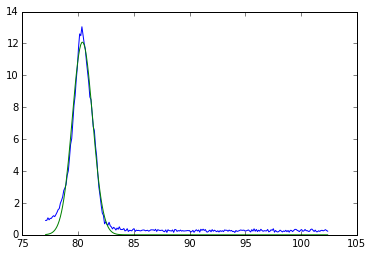

In [824]:
popt, pcov = curve_fit(gauss, energies[750:1000], ba133[750:1000], p0=[1, 88.04, 0.8])
print(popt)
plt.plot(energies[750:1000], ba133[750:1000])
plt.plot(energies[750:1000], gauss(energies[750:1000], *popt))
plt.ylim(0,14)
plt.show()

In [825]:
print("Area under the curve: {}".format(
    sum([ba133[i] for i in range(len(ba133)) if ba133[i] > 0 ])
))
print("Photopeak efficiency: {}".format(
    popt[2] / sum([ba133[i] for i in range(len(ba133)) if ba133[i] > 0 ])
))

Area under the curve: 1509.79
Photopeak efficiency: 0.0129011765531


In [826]:
print(popt[1])
print("FWHM: {}".format(sigma2fwhm(popt[1])))
print("Resolution: {}".format(sigma2res(popt[1], popt[0])))

-0.642582712505
FWHM: 1.513166652
Resolution: 53.1330481475


### 276 keV

[ 276.39533852    0.5795431     2.51974094]


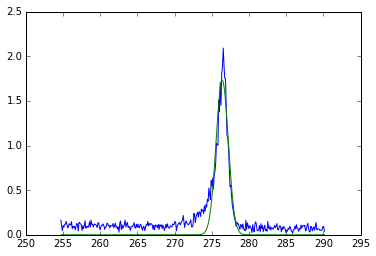

In [827]:
popt, pcov = curve_fit(gauss, energies[2500:2850], ba133[2500:2850], p0=[1, 88.04, 0.8])
print(popt)
plt.plot(energies[2500:2850], ba133[2500:2850])
plt.plot(energies[2500:2850], gauss(energies[2500:2850], *popt))
plt.ylim(0,2.5)
plt.show()

In [828]:
print("Area under the curve: {}".format(
    sum([ba133[i] for i in range(len(ba133)) if ba133[i] > 0 ])
))
print("Photopeak efficiency: {}".format(
    popt[2] / sum([ba133[i] for i in range(len(ba133)) if ba133[i] > 0 ])
))

Area under the curve: 1509.79
Photopeak efficiency: 0.001668934716


In [829]:
print(popt[1])
print("FWHM: {}".format(sigma2fwhm(popt[1])))
print("Resolution: {}".format(sigma2res(popt[1], popt[0])))

0.579543103086
FWHM: 1.36471971611
Resolution: 202.529014021


### 303 keV

[ 302.82358473    0.57861487    5.61274722]


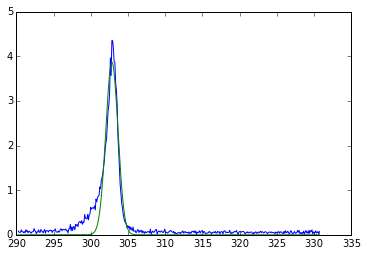

In [830]:
popt, pcov = curve_fit(gauss, energies[2850:3250], ba133[2850:3250], p0=[1, 302, 0.8])
print(popt)
plt.plot(energies[2850:3250], ba133[2850:3250])
plt.plot(energies[2850:3250], gauss(energies[2850:3250], *popt))
plt.ylim(0,5)
plt.show()

In [831]:
print("Area under the curve: {}".format(
    sum([ba133[i] for i in range(len(ba133)) if ba133[i] > 0 ])
))
print("Photopeak efficiency: {}".format(
    popt[2] / sum([ba133[i] for i in range(len(ba133)) if ba133[i] > 0 ])
))

Area under the curve: 1509.79
Photopeak efficiency: 0.00371756815424


In [832]:
print(popt[1])
print("FWHM: {}".format(sigma2fwhm(popt[1])))
print("Resolution: {}".format(sigma2res(popt[1], popt[0])))

0.578614867302
FWHM: 1.36253388788
Resolution: 222.250314232


### 356 keV

[ 355.92859069   -0.59989225   15.03204682]


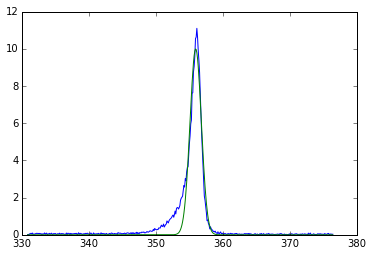

In [833]:
popt, pcov = curve_fit(gauss, energies[3250:3700], ba133[3250:3700], p0=[1, 356, 0.8])
print(popt)
plt.plot(energies[3250:3700], ba133[3250:3700])
plt.plot(energies[3250:3700], gauss(energies[3250:3700], *popt))
plt.ylim(0,12)
plt.show()

In [834]:
print("Area under the curve: {}".format(
    sum([ba133[i] for i in range(len(ba133)) if ba133[i] > 0 ])
))
print("Photopeak efficiency: {}".format(
    popt[2] / sum([ba133[i] for i in range(len(ba133)) if ba133[i] > 0 ])
))

Area under the curve: 1509.79
Photopeak efficiency: 0.00995638255618


In [835]:
print(popt[1])
print("FWHM: {}".format(sigma2fwhm(popt[1])))
print("Resolution: {}".format(sigma2res(popt[1], popt[0])))

-0.599892246529
FWHM: 1.41263828698
Resolution: 251.960175487


### 384 keV

[ 383.74293566   -0.6488432     2.1091301 ]


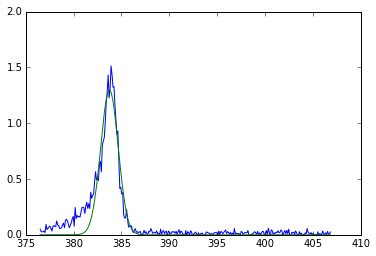

In [836]:
popt, pcov = curve_fit(gauss, energies[3700:4000], ba133[3700:4000], p0=[1, 385, 0.8])
print(popt)
plt.plot(energies[3700:4000], ba133[3700:4000])
plt.plot(energies[3700:4000], gauss(energies[3700:4000], *popt))
plt.ylim(0,2)
plt.show()

In [837]:
print("Area under the curve: {}".format(
    sum([ba133[i] for i in range(len(ba133)) if ba133[i] > 0 ])
))
print("Photopeak efficiency: {}".format(
    popt[2] / sum([ba133[i] for i in range(len(ba133)) if ba133[i] > 0 ])
))

Area under the curve: 1509.79
Photopeak efficiency: 0.00139696918285


In [838]:
print(popt[1])
print("FWHM: {}".format(sigma2fwhm(popt[1])))
print("Resolution: {}".format(sigma2res(popt[1], popt[0])))

-0.648843203241
FWHM: 1.52790898107
Resolution: 251.155625378


## Cs-137

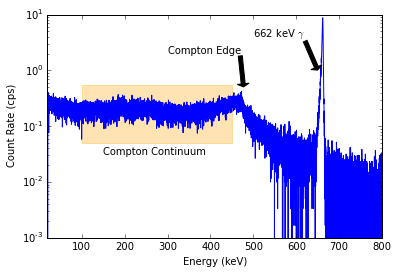

In [839]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.plot(energies, cs137)
ax1.set_xlim([20,800])
ax1.set_yscale('log')
ax1.set_ylabel("Count Rate (cps)")
ax1.set_xlabel("Energy (keV)")
# ax1.set_title("Cs-137 Spectrum with HPGE Detector")
ax1.annotate('Compton Edge', xy=(477,0.5), 
             xytext=(300,2), arrowprops=dict(facecolor="black", shrink=0.01))
ax1.annotate(r'662 keV $\gamma$', xy=(650,1), 
             xytext=(500,4), arrowprops=dict(facecolor="black", shrink=0.01))
ax1.add_patch(
    patches.Rectangle(
        (100,0.05),
        350, 
        0.5,
        alpha=0.3,
        color="orange"
    )
)
ax1.text(150,0.03,"Compton Continuum")
plt.show()

### 662 keV

[ 661.2394476     0.77372839   15.33106113]


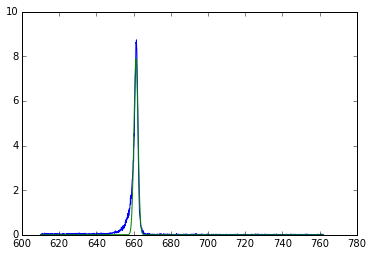

In [840]:
popt, pcov = curve_fit(gauss, energies[6000:7500], cs137[6000:7500], p0=[1, 385, 0.8])
print(popt)
plt.plot(energies[6000:7500], cs137[6000:7500])
plt.plot(energies[6000:7500], gauss(energies[6000:7500], *popt))
plt.ylim(0,10)
plt.show()

In [841]:
661.7 * (1 - (1 / (1 + 2 * 661.7 / 511)))

477.3734081988661

In [842]:
print("Area under the curve: {}".format(
    sum([cs137[i] for i in range(len(cs137)) if cs137[i] > 0 ])
))
print("Photopeak efficiency: {}".format(
    popt[2] / sum([cs137[i] for i in range(len(cs137)) if cs137[i] > 0 ])
))

Area under the curve: 1333.6
Photopeak efficiency: 0.0114959966472


In [843]:
print(popt[1])
print("FWHM: {}".format(sigma2fwhm(popt[1])))
print("Resolution: {}".format(sigma2res(popt[1], popt[0])))

0.773728391329
FWHM: 1.82199112531
Resolution: 362.921332829


# Spectroscopy with CZT Detector

In [844]:
datadir = os.path.join(rootdatadir, "czt/")

### Loading Data

In [845]:
def bgcorrcountrate(spefile, datadir=datadir, bgfile="Background_600sec.Spe"):
    d = spedata(spefile, datadir) / spetime(spefile, datadir)
    b = spedata(bgfile, datadir) / spetime(bgfile, datadir)
    
    c = np.array(d - b)
    c[c < 0] = 0
    return c

In [846]:
na22 = bgcorrcountrate("Na_22_300sec.Spe")
co57 = bgcorrcountrate("Co_57_300sec.Spe")
co60 = bgcorrcountrate("Co_60_600sec.Spe")
cd109 = bgcorrcountrate("Cd_109_300sec.Spe")
ba133 = bgcorrcountrate("Ba_133_300sec.Spe")
cs137 = bgcorrcountrate("Cs_137_120sec.Spe")

## Let's find those peaks!

In [847]:
peak_energies = []
peak_channels = []

### Na-22

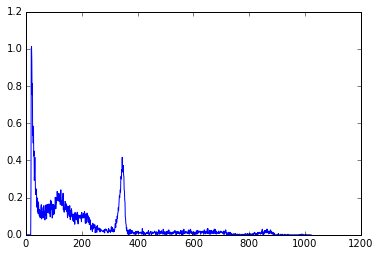

In [848]:
plt.plot(na22)
#plt.xlim(0,400)
plt.show()

In [849]:
start = 250
pk.indexes(na22[start:], thres=0.5, min_dist=30) + start

array([345])

In [850]:
map(peak_energies.append, [511])
map(peak_channels.append, pk.indexes(na22[start:], thres=0.5, min_dist=30) + start)

[None]

### Co-57

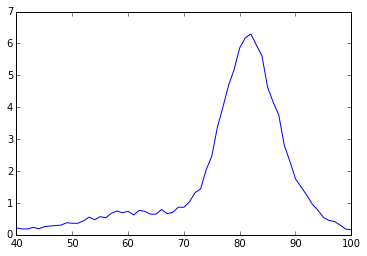

In [851]:
plt.plot(co57)
plt.xlim(40,100)
plt.show()

In [852]:
start = 40
pk.indexes(co57[start:100], thres=0.9, min_dist=30) + start

array([82])

In [853]:
map(peak_energies.append, [122])
map(peak_channels.append, pk.indexes(co57[start:100], thres=0.9, min_dist=30) + start)

[None]

### Co-60

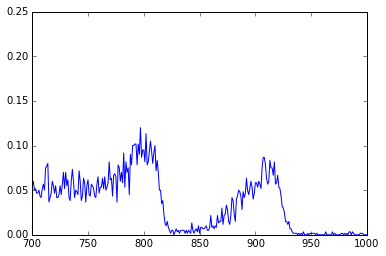

In [854]:
plt.plot(co60)
plt.xlim(700,1000)
plt.show()

In [855]:
start = 700
pk.indexes(co60[start:], thres=0.7, min_dist=30) + start

array([797, 907])

In [856]:
map(peak_energies.append, [1173, 1332])
map(peak_channels.append, pk.indexes(co60[start:], thres=0.7, min_dist=30) + start)

[None, None]

### Cd-109

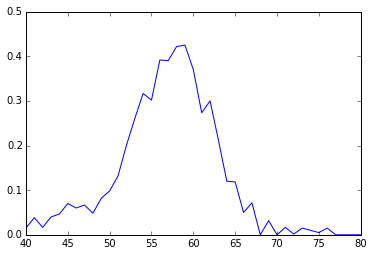

In [857]:
plt.plot(cd109)
plt.xlim(40,80)
plt.ylim(0,0.5)
plt.show()

In [858]:
start = 40
pk.indexes(cd109[start:], thres=0.7, min_dist=30) + start

array([59])

In [859]:
map(peak_energies.append, [88.04])
map(peak_channels.append, pk.indexes(cd109[start:], thres=0.7, min_dist=30) + start)

[None]

### Ba-133

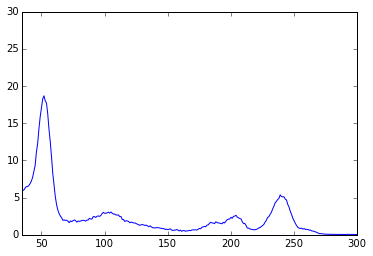

In [860]:
plt.plot(ba133)
plt.xlim(35,300)
plt.show()

In [861]:
start = 35
pk.indexes(ba133[start:], thres=0.2, min_dist=10) + start

array([ 52, 239])

In [862]:
map(peak_energies.append, [80.99, 356.017])
map(peak_channels.append, pk.indexes(ba133[start:], thres=0.2, min_dist=10) + start)

[None, None]

### Cs-137

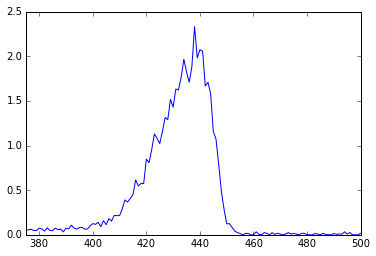

In [863]:
plt.plot(cs137[10:])
plt.xlim(375,500)
plt.show()

In [864]:
start = 375
pk.indexes(cs137[start:], thres=0.2, min_dist=50) + start

array([448])

In [865]:
map(peak_energies.append, [662])
map(peak_channels.append, pk.indexes(cs137[start:], thres=0.2, min_dist=50) + start)

[None]

In [866]:
print(peak_energies)
print(peak_channels)
fit = stats.linregress(peak_channels, peak_energies)
print fit.rvalue ** 2

[511, 122, 1173, 1332, 88.04, 80.99, 356.017, 662]
[345, 82, 797, 907, 59, 52, 239, 448]
0.999987961764


1.46647574024 * x + 3.71744460556


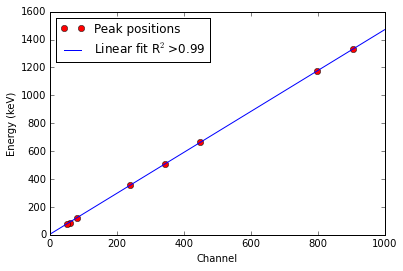

In [867]:
plt.plot(peak_channels, peak_energies, 'ro', label="Peak positions")
c2eczt = lambda x: fit.slope * x + fit.intercept
print("{} * x + {}".format(fit.slope, fit.intercept))
energies = c2eczt(np.arange(0,len(na22),1))
plt.plot(np.linspace(0,1000,1000), c2eczt(np.linspace(0,1000,1000)), 
         label=r'Linear fit R$^2$>0.99')
plt.xlabel("Channel")
plt.ylabel("Energy (keV)")
# plt.title("Energy vs. Channel for CZT Detector")
plt.legend(loc="upper left")
plt.show()

In [868]:
e2cczt = lambda x: int((x - fit.intercept) / fit.slope)

## Isotope analysis

### Na-22

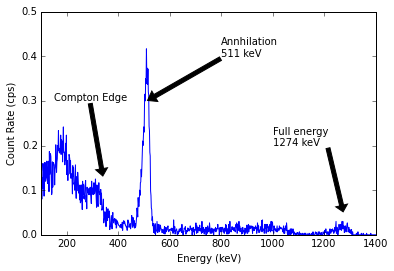

In [869]:
plt.plot(energies, na22)
plt.ylim(0,0.5)
plt.xlim(100,1400)
plt.ylabel("Count Rate (cps)")
plt.xlabel("Energy (keV)")
# plt.title("Na-22 Spectrum with CZT Detector")
plt.annotate('Full energy\n1274 keV', xy=(1274,0.05),
             xytext=(1000,0.2), arrowprops=dict(facecolor="black", shrink=0.01))
plt.annotate('Annhilation\n511 keV', xy=(511,0.3),
             xytext=(800,0.4), arrowprops=dict(facecolor="black", shrink=0.01))
plt.annotate('Compton Edge', xy=(0.667*511,0.13),
             xytext=(150,0.3), arrowprops=dict(facecolor="black", shrink=0.01))
plt.show()

#### 511 keV peak

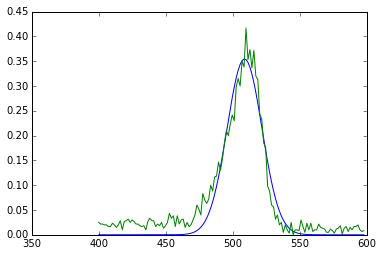

In [870]:
popt, pcov = curve_fit(gauss, energies[e2cczt(400):e2cczt(600)], na22[e2cczt(400):e2cczt(600)], p0=[100, 511, 0.8])
plt.plot(energies[e2cczt(400):e2cczt(600)], gauss(energies[e2cczt(400):e2cczt(600)], *popt))
plt.plot(energies[e2cczt(400):e2cczt(600)], na22[e2cczt(400):e2cczt(600)])
plt.show()

In [871]:
popt

array([ 508.54684425,    9.20260676,    8.17928527])

In [872]:
print("Area under the curve: {}".format(
    sum([na22[i] for i in range(len(na22)) if na22[i] > 0 ])))
print("Photopeak efficiency: {}".format(
    popt[2] / sum([na22[i] for i in range(len(na22)) if na22[i] > 0 ])))

Area under the curve: 50.825
Photopeak efficiency: 0.160930354531


In [873]:
print(popt[1])
print("FWHM: {}".format(sigma2fwhm(popt[1])))
print("Resolution: {}".format(sigma2res(popt[1], popt[0])))

9.20260675831
FWHM: 21.670482861
Resolution: 23.467259475


#### 1274 keV peak

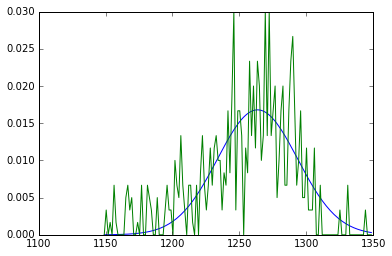

In [874]:
popt, pcov = curve_fit(
    gauss, 
    energies[e2cczt(1150):e2cczt(1350)], 
    na22[e2cczt(1150):e2cczt(1350)], 
    p0=[100, 511, 0.8]
)
plt.plot(
    energies[e2cczt(1150):e2cczt(1350)], 
    gauss(energies[e2cczt(1150):e2cczt(1350)], *popt)
)
plt.plot(
    energies[e2cczt(1150):e2cczt(1350)], 
    na22[e2cczt(1150):e2cczt(1350)]
)
plt.show()

In [875]:
popt

array([  1.26352340e+03,  -2.11930511e+01,   8.92222728e-01])

In [876]:
print("Area under the curve: {}".format(
    sum([na22[i] for i in range(len(na22)) if na22[i] > 0 ])))
print("Photopeak efficiency: {}".format(
    popt[2] / sum([na22[i] for i in range(len(na22)) if na22[i] > 0 ])))

Area under the curve: 50.825
Photopeak efficiency: 0.0175548003496


In [877]:
print(popt[1])
print("FWHM: {}".format(sigma2fwhm(popt[1])))
print("Resolution: {}".format(sigma2res(popt[1], popt[0])))

-21.1930511478
FWHM: 49.9058216581
Resolution: 25.3181563578


### Co-57

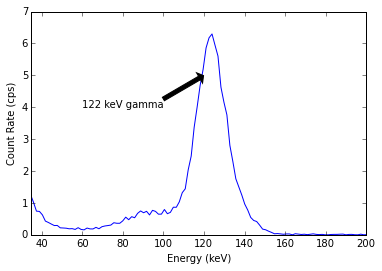

In [878]:
plt.plot(energies, co57)
#plt.ylim(0,0.5)
plt.xlim(35,200)
plt.ylabel("Count Rate (cps)")
plt.xlabel("Energy (keV)")
# plt.title("Co-57 Spectrum with CZT Detector")
plt.annotate('122 keV gamma', xy=(120,5),
             xytext=(60,4), arrowprops=dict(facecolor="black", shrink=0.01))
plt.show()

#### 122 keV

[ 123.53179942   -5.71704796   85.30029907]


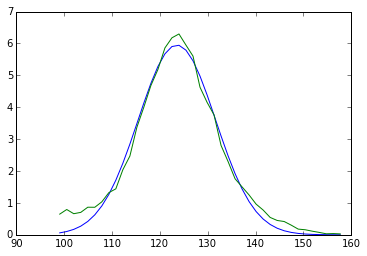

In [879]:
r_low = e2cczt(100)

r_high = e2cczt(160)
popt, pcov = curve_fit(gauss, energies[r_low:r_high], 
    co57[r_low:r_high], p0=[122, 20, 20])
plt.plot(energies[r_low:r_high], 
         gauss(energies[r_low:r_high], *popt))
plt.plot(energies[r_low:r_high], 
         co57[r_low:r_high])
print(popt)
plt.show()

In [880]:
popt

array([ 123.53179942,   -5.71704796,   85.30029907])

In [881]:
ph = co57
print("Area under the curve: {}".format(
    sum([ph[i] for i in range(len(ph)) if ph[i] > 0 ])))
print("Photopeak efficiency: {}".format(
    popt[2] / sum([ph[i] for i in range(len(ph)) if ph[i] > 0 ])))

Area under the curve: 110.97
Photopeak efficiency: 0.768678913807


In [882]:
print(popt[1])
print("FWHM: {}".format(sigma2fwhm(popt[1])))
print("Resolution: {}".format(sigma2res(popt[1], popt[0])))

-5.71704795532
FWHM: 13.4626191236
Resolution: 9.17591133506


### Co-60

In [883]:
ph = co60

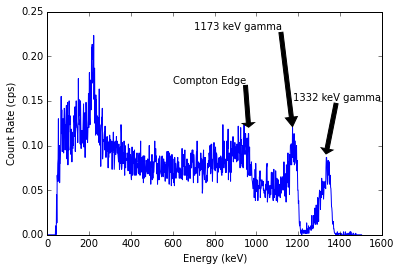

In [884]:
plt.plot(energies, ph)
plt.ylabel("Count Rate (cps)")
plt.xlabel("Energy (keV)")
# plt.title("Co-60 Spectrum with CZT Detector")
plt.annotate('1173 keV gamma', xy=(1173,0.12),
             xytext=(700,0.23), arrowprops=dict(facecolor="black", shrink=0.01))
plt.annotate('1332 keV gamma', xy=(1332,0.09),
             xytext=(1173,0.15), arrowprops=dict(facecolor="black", shrink=0.01))
plt.annotate('Compton Edge', xy=(963,0.12),
             xytext=(600,0.17), arrowprops=dict(facecolor="black", shrink=0.01))
plt.show()

#### 1173 keV

[ 1158.62278797    25.51714351     5.71585089]


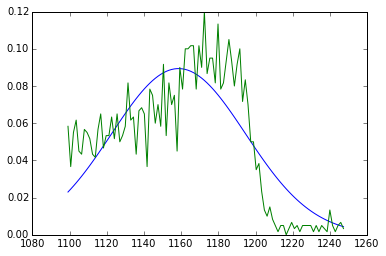

In [885]:
r_low = e2cczt(1100)
r_high = e2cczt(1250)

popt, pcov = curve_fit(gauss, energies[r_low:r_high], 
    ph[r_low:r_high], p0=[1173, 20, 20])
plt.plot(energies[r_low:r_high], 
         gauss(energies[r_low:r_high], *popt))
plt.plot(energies[r_low:r_high], 
         ph[r_low:r_high])
print(popt)
plt.show()

In [886]:
print("Area under the curve: {}".format(
    sum([ph[i] for i in range(len(ph)) if ph[i] > 0 ])))
print("Photopeak efficiency: {}".format(
    popt[2] / sum([ph[i] for i in range(len(ph)) if ph[i] > 0 ])))

Area under the curve: 71.5166666667
Photopeak efficiency: 0.0799233403122


In [887]:
print(popt[1])
print("FWHM: {}".format(sigma2fwhm(popt[1])))
print("Resolution: {}".format(sigma2res(popt[1], popt[0])))

25.5171435111
FWHM: 60.0882810319
Resolution: 19.2820092049


#### 1332 keV

[ 1329.59603841    18.32897608     3.13340771]


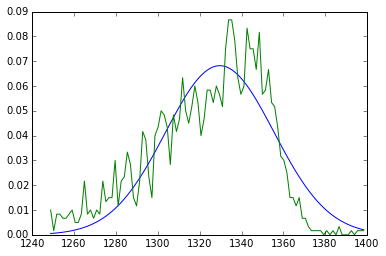

In [888]:
r_low = e2cczt(1250)
r_high = e2cczt(1400)

popt, pcov = curve_fit(gauss, energies[r_low:r_high], 
    ph[r_low:r_high], p0=[1332, 20, 20])
plt.plot(energies[r_low:r_high], 
         gauss(energies[r_low:r_high], *popt))
plt.plot(energies[r_low:r_high], 
         ph[r_low:r_high])
print(popt)
plt.show()

In [889]:
print("Area under the curve: {}".format(
    sum([ph[i] for i in range(len(ph)) if ph[i] > 0 ])))
print("Photopeak efficiency: {}".format(
    popt[2] / sum([ph[i] for i in range(len(ph)) if ph[i] > 0 ])))

Area under the curve: 71.5166666667
Photopeak efficiency: 0.043813671039


In [890]:
print(popt[1])
print("FWHM: {}".format(sigma2fwhm(popt[1])))
print("Resolution: {}".format(sigma2res(popt[1], popt[0])))

18.3289760794
FWHM: 43.1614402766
Resolution: 30.8051823546


### Cd-109

In [891]:
ph = cd109

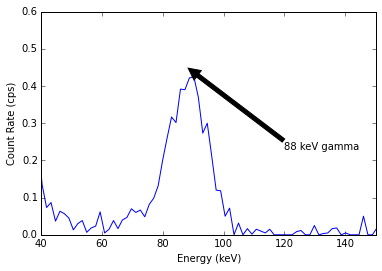

In [892]:
plt.plot(energies, ph)
plt.xlim(40,150)
plt.ylim(0,0.6)
plt.ylabel("Count Rate (cps)")
plt.xlabel("Energy (keV)")
# plt.title("Cd-109 Spectrum with CZT Detector")
plt.annotate('88 keV gamma', xy=(88.04,0.45),
             xytext=(120,0.23), arrowprops=dict(facecolor="black", shrink=0.01))
plt.show()

#### 88.04 keV

[ 88.14872398   4.82522471   4.94324523]


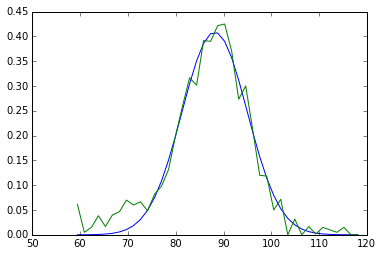

Area under the curve: 13.0983333333
Photopeak efficiency: 0.377394978811


In [893]:
r_low = e2cczt(60)
r_high = e2cczt(120)

popt, pcov = curve_fit(gauss, energies[r_low:r_high], 
    ph[r_low:r_high], p0=[88, 20, 20])
plt.plot(energies[r_low:r_high], 
         gauss(energies[r_low:r_high], *popt))
plt.plot(energies[r_low:r_high], 
         ph[r_low:r_high])
print(popt)
plt.show()
print("Area under the curve: {}".format(
    sum([ph[i] for i in range(len(ph)) if ph[i] > 0 ])))
print("Photopeak efficiency: {}".format(
    popt[2] / sum([ph[i] for i in range(len(ph)) if ph[i] > 0 ])))

In [894]:
print(popt[1])
print("FWHM: {}".format(sigma2fwhm(popt[1])))
print("Resolution: {}".format(sigma2res(popt[1], popt[0])))

4.82522471218
FWHM: 11.362535874
Resolution: 7.75783900365


### Ba-133

In [895]:
ph = ba133

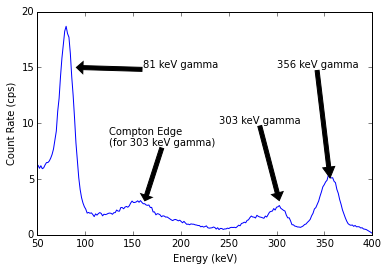

In [896]:
ph = ba133
plt.plot(energies, ph)
plt.xlim(50,400)
plt.ylim(0,20)
plt.ylabel("Count Rate (cps)")
plt.xlabel("Energy (keV)")
# plt.title("Ba-133 Spectrum with CZT Detector")
plt.annotate('356 keV gamma', xy=(356,5),
             xytext=(300,15), arrowprops=dict(facecolor="black", shrink=0.01))
plt.annotate('303 keV gamma', xy=(303,3),
             xytext=(240,10), arrowprops=dict(facecolor="black", shrink=0.01))
plt.annotate('Compton Edge\n(for 303 keV gamma)', xy=(162,3),
             xytext=(125,8), arrowprops=dict(facecolor="black", shrink=0.01))
plt.annotate('81 keV gamma', xy=(90,15),
             xytext=(160,15), arrowprops=dict(facecolor="black", shrink=0.01))
plt.show()

#### 80.99 keV

[  77.99038306   -8.81102742  348.97379974]


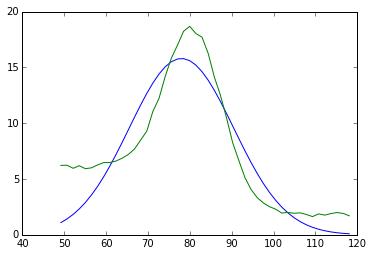

Area under the curve: 879.76
Photopeak efficiency: 0.396669318609


In [897]:
r_low = e2cczt(50)
r_high = e2cczt(120)

popt, pcov = curve_fit(gauss, energies[r_low:r_high], 
    ph[r_low:r_high], p0=[80, 20, 20])
plt.plot(energies[r_low:r_high], 
         gauss(energies[r_low:r_high], *popt))
plt.plot(energies[r_low:r_high], 
         ph[r_low:r_high])
print(popt)
plt.show()
print("Area under the curve: {}".format(
    sum([ph[i] for i in range(len(ph)) if ph[i] > 0 ])))
print("Photopeak efficiency: {}".format(
    popt[2] / sum([ph[i] for i in range(len(ph)) if ph[i] > 0 ])))

In [898]:
print(popt[1])
print("FWHM: {}".format(sigma2fwhm(popt[1])))
print("Resolution: {}".format(sigma2res(popt[1], popt[0])))

-8.81102741606
FWHM: 20.7483839767
Resolution: 3.75886542032


#### 356 keV

[ 354.733575     -8.37302008  106.49413438]


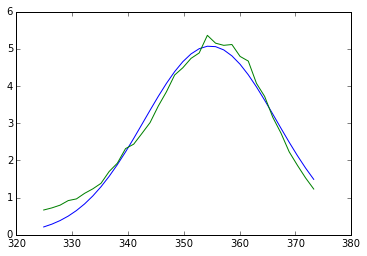

Area under the curve: 879.76
Photopeak efficiency: 0.121049075178


In [899]:
r_low = e2cczt(325)
r_high = e2cczt(375)

popt, pcov = curve_fit(gauss, energies[r_low:r_high], 
    ph[r_low:r_high], p0=[350, 20, 20])
plt.plot(energies[r_low:r_high], 
         gauss(energies[r_low:r_high], *popt))
plt.plot(energies[r_low:r_high], 
         ph[r_low:r_high])
print(popt)
plt.show()
print("Area under the curve: {}".format(
    sum([ph[i] for i in range(len(ph)) if ph[i] > 0 ])))
print("Photopeak efficiency: {}".format(
    popt[2] / sum([ph[i] for i in range(len(ph)) if ph[i] > 0 ])))

In [900]:
print(popt[1])
print("FWHM: {}".format(sigma2fwhm(popt[1])))
print("Resolution: {}".format(sigma2res(popt[1], popt[0])))

-8.37302007624
FWHM: 19.716955513
Resolution: 17.9912956016


### Cs-137

In [901]:
ph = cs137

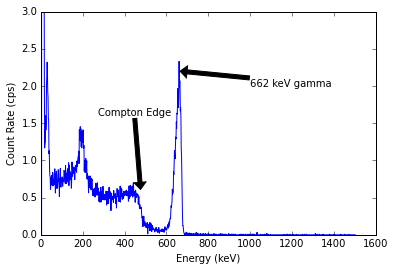

In [902]:
plt.plot(energies, ph)
plt.ylim(0,3)
plt.ylabel("Count Rate (cps)")
plt.xlabel("Energy (keV)")
# plt.title("Cs-137 Spectrum with CZT Detector")
plt.annotate('662 keV gamma', xy=(662,2.2),
             xytext=(1000,2.0), arrowprops=dict(facecolor="black", shrink=0.01))
plt.annotate('Compton Edge', xy=(477,0.6),
             xytext=(275,1.6), arrowprops=dict(facecolor="black", shrink=0.01))
plt.show()

#### 662 keV

[ 655.89639424   10.03084027   49.29468118]


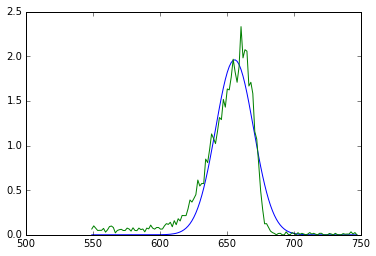

Area under the curve: 4314.365
Photopeak efficiency: 0.0114257095028


In [903]:
r_low = e2cczt(550)
r_high = e2cczt(750)

popt, pcov = curve_fit(gauss, energies[r_low:r_high], 
    ph[r_low:r_high], p0=[662, 20, 20])
plt.plot(energies[r_low:r_high], 
         gauss(energies[r_low:r_high], *popt))
plt.plot(energies[r_low:r_high], 
         ph[r_low:r_high])
print(popt)
plt.show()
print("Area under the curve: {}".format(
    sum([ph[i] for i in range(len(ph)) if ph[i] > 0 ])))
print("Photopeak efficiency: {}".format(
    popt[2] / sum([ph[i] for i in range(len(ph)) if ph[i] > 0 ])))

In [904]:
print(popt[1])
print("FWHM: {}".format(sigma2fwhm(popt[1])))
print("Resolution: {}".format(sigma2res(popt[1], popt[0])))

10.0308402732
FWHM: 23.6208237438
Resolution: 27.7677189143


# Cs-137 distances

In [906]:
dir = os.path.join(rootdatadir, "maestro", "Spectra")
files = [i for i in os.listdir(dir) if "lab83Cs" in i]
print(files)

['lab83Cs0cm.Spe', 'lab83Cs11.5cm.Spe', 'lab83Cs14.7.Spe', 'lab83Cs2.6cm.Spe', 'lab83Cs6.2cm.Spe', 'lab83Cs9.4cm.Spe']


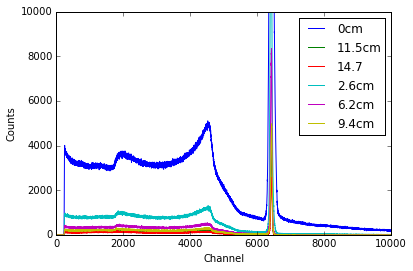

In [913]:
for f in files:
    data = spedata(f, dir)
    plt.plot(data, label=f[7:-4])
plt.legend()
plt.ylim(0,10000)
plt.xlim(0,10000)
plt.ylabel("Counts")
plt.xlabel("Channel")
plt.show()